In [49]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utils import evaluate
from xgboost import XGBClassifier


In [25]:
df = pd.read_csv('database/final.csv')
df


,Unnamed: 0,ID,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. Weeks,Weight(g),...,Median UC,Std FHR,Std UC,RMS FHR,RMS UC,Peak to RMS FHR,Peak to RMS UC,Peak FHR,Peak UC,target
0,0,1220.000000,7.300000,3.520000,6.000000,-4.700000,9.000000,10.000000,42.000000,3100.000000,...,23.000000,59.376698,21.970835,122.357020,33.143752,70.642980,93.856248,193.000000,127.000000,1.0
1,1,1234.000000,7.290000,2.500000,6.500000,-4.200000,8.000000,9.000000,41.000000,3200.000000,...,20.500000,59.311329,24.685834,135.710988,34.975993,88.289012,92.024007,224.000000,127.000000,1.0
2,2,1208.000000,7.230000,5.840000,6.600000,-7.400000,9.000000,9.000000,40.000000,3900.000000,...,3.000000,51.554942,21.705502,109.963878,26.323443,64.536122,73.676557,174.500000,100.000000,1.0
3,3,1038.000000,7.330000,2.720000,5.700000,-4.000000,10.000000,10.000000,39.000000,2740.000000,...,6.000000,26.070361,30.393657,135.560556,37.570082,31.189444,62.429918,166.750000,100.000000,1.0
4,4,1004.000000,7.300000,5.190000,5.500000,-6.400000,8.000000,9.000000,41.000000,3370.000000,...,14.000000,51.581668,16.210997,105.951334,22.315540,123.048666,100.684460,229.000000,123.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,970,1612.415502,7.277141,4.170062,6.214293,-5.257210,8.285658,8.714244,39.571415,4014.282925,...,13.642683,66.893660,15.123756,112.954032,21.790416,87.188871,69.994656,200.142902,91.785073,0.0
971,971,1767.337796,7.293675,3.440918,6.131623,-4.463584,8.947013,9.210260,39.736753,4047.350650,...,15.709416,62.683887,17.396235,103.389556,25.123933,96.215996,74.266717,199.605552,99.390650,0.0
972,972,1481.788323,7.230459,4.115599,7.287158,-5.830279,9.440366,10.000000,40.559634,4038.440290,...,15.922014,64.601882,18.569339,109.909654,26.431828,77.227946,77.513116,187.137600,103.944945,0.0
973,973,1199.005821,7.233021,6.115778,6.434896,-7.374997,6.520836,7.390627,39.130209,3926.041797,...,8.127612,78.127428,9.059652,138.476805,12.894938,63.100015,58.594676,201.576821,71.489613,0.0


In [26]:
# droping unnecessary columns
df.drop(['Unnamed: 0', 'ID'], axis=1, inplace=True)
df.shape


(975, 42)

In [27]:
df.isnull().sum().sum()  # checking for null values


0

In [28]:
df.columns


Index(['pH', 'BDecf', 'pCO2', 'BE', 'Apgar1', 'Apgar5', 'Gest. Weeks',
       'Weight(g)', 'Sex', 'Age', 'Gravidity', 'Parity', 'Diabetes',
       'Hypertension', 'Preeclampsia', 'Liq.', 'Pyrexia', 'Meconium',
       'Presentation', 'Induced', 'I.stage', 'NoProgress', 'CK/KP', 'II.stage',
       'Deliv. type', 'dbID', 'Rec. type', 'Pos. II.st.', 'Sig2Birth',
       'Mean FHR', 'Mean UC', 'Median FHR', 'Median UC', 'Std FHR', 'Std UC',
       'RMS FHR', 'RMS UC', 'Peak to RMS FHR', 'Peak to RMS UC', 'Peak FHR',
       'Peak UC', 'target'],
      dtype='object')

# Feature Engineering

In [29]:
def f(x):
    if 6.5 < x <= 10:
        return 'Excellent'
    elif 4 < x <= 6.5:
        return 'ModeratelyAbnormal'
    elif x <= 4:
        return 'Attention'


In [30]:
df['Apgar1'] = df['Apgar1'].apply(lambda x: f(x))
df['Apgar5'] = df['Apgar5'].apply(lambda x: f(x))


In [31]:
df.Apgar1.value_counts()


Excellent             901
ModeratelyAbnormal     47
Attention              27
Name: Apgar1, dtype: int64

In [32]:
df.Apgar5.value_counts()


Excellent             957
ModeratelyAbnormal     15
Attention               3
Name: Apgar5, dtype: int64

In [33]:
df.target.value_counts()


1.0    488
0.0    487
Name: target, dtype: int64

In [34]:
df['pH'] = df['pH'].apply(lambda x: 'Pathological' if x <= 7.15 else 'Normal')

df.pH.value_counts()


Normal          842
Pathological    133
Name: pH, dtype: int64

In [35]:
# one hot encoding
dts = pd.get_dummies(df)
df.shape


(975, 42)

In [36]:
dts.head()


,BDecf,pCO2,BE,Gest. Weeks,Weight(g),Sex,Age,Gravidity,Parity,Diabetes,...,Peak UC,target,pH_Normal,pH_Pathological,Apgar1_Attention,Apgar1_Excellent,Apgar1_ModeratelyAbnormal,Apgar5_Attention,Apgar5_Excellent,Apgar5_ModeratelyAbnormal
0,3.52,6.0,-4.7,42.0,3100.0,2.0,34.0,2.0,2.0,0.0,...,127.0,1.0,1,0,0,1,0,0,1,0
1,2.50,6.5,-4.2,41.0,3200.0,1.0,29.0,1.0,0.0,0.0,...,127.0,1.0,1,0,0,1,0,0,1,0
2,5.84,6.6,-7.4,40.0,3900.0,2.0,26.0,1.0,0.0,0.0,...,100.0,1.0,1,0,0,1,0,0,1,0
3,2.72,5.7,-4.0,39.0,2740.0,1.0,24.0,1.0,1.0,0.0,...,100.0,1.0,1,0,0,1,0,0,1,0
4,5.19,5.5,-6.4,41.0,3370.0,1.0,36.0,1.0,0.0,0.0,...,123.0,1.0,1,0,0,1,0,0,1,0


In [37]:
dts.columns


Index(['BDecf', 'pCO2', 'BE', 'Gest. Weeks', 'Weight(g)', 'Sex', 'Age',
       'Gravidity', 'Parity', 'Diabetes', 'Hypertension', 'Preeclampsia',
       'Liq.', 'Pyrexia', 'Meconium', 'Presentation', 'Induced', 'I.stage',
       'NoProgress', 'CK/KP', 'II.stage', 'Deliv. type', 'dbID', 'Rec. type',
       'Pos. II.st.', 'Sig2Birth', 'Mean FHR', 'Mean UC', 'Median FHR',
       'Median UC', 'Std FHR', 'Std UC', 'RMS FHR', 'RMS UC',
       'Peak to RMS FHR', 'Peak to RMS UC', 'Peak FHR', 'Peak UC', 'target',
       'pH_Normal', 'pH_Pathological', 'Apgar1_Attention', 'Apgar1_Excellent',
       'Apgar1_ModeratelyAbnormal', 'Apgar5_Attention', 'Apgar5_Excellent',
       'Apgar5_ModeratelyAbnormal'],
      dtype='object')

In [38]:
X = dts.drop('target', axis=1)
y = dts['target']


# Test  Train Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print('Training dataset len: {}, Test data len: {}'.format(
    X_train.shape[0], y_test.shape[0]))


Training dataset len: 780, Test data len: 195


# Scaling Dataset

In [40]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.transform(X_test)


# Training Different Models

## KNN

In [41]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)


KNeighborsClassifier()

In [42]:
y_pred = model_knn.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 82.56%


In [43]:
evaluate.evaluate_model(model_knn, X_test, y_test)


Accuracy:- 82.56%
Confusion matrix :- 
 [[97  0]
 [34 64]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        97
         1.0       1.00      0.65      0.79        98

    accuracy                           0.83       195
   macro avg       0.87      0.83      0.82       195
weighted avg       0.87      0.83      0.82       195



## Support Vector Machines

In [44]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 88.21%
Confusion matrix :- 
 [[94  3]
 [20 78]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.82      0.97      0.89        97
         1.0       0.96      0.80      0.87        98

    accuracy                           0.88       195
   macro avg       0.89      0.88      0.88       195
weighted avg       0.89      0.88      0.88       195



In [45]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 95.90%
Confusion matrix :- 
 [[97  0]
 [ 8 90]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        97
         1.0       1.00      0.92      0.96        98

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



## Random Forest Classifier

In [48]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 98.97%
Confusion matrix :- 
 [[97  0]
 [ 2 96]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        97
         1.0       1.00      0.98      0.99        98

    accuracy                           0.99       195
   macro avg       0.99      0.99      0.99       195
weighted avg       0.99      0.99      0.99       195



## XGBoost

In [46]:
model = XGBClassifier()
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


[15:55:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\AnantGupta\Anaconda3\envs\mainenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy:- 94.36%
Confusion matrix :- 
 [[93  4]
 [ 7 91]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94        97
         1.0       0.96      0.93      0.94        98

    accuracy                           0.94       195
   macro avg       0.94      0.94      0.94       195
weighted avg       0.94      0.94      0.94       195



# Hyperparameter Tuning with Grid Search

So, we have 3 candidates who performed well XGboost, Randomforest, SVM (rbf kernel)

In [57]:
def hyperparameter_tuning(model, parameters, X_train, y_train):

    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5,  n_jobs=5,
                        scoring='roc_auc', refit=True, verbose=1)

    grid.fit(X_train, y_train)
    print("Best Score: {:.2f}%".format(grid.best_score_*100))
    print("Best Parameters:", grid.best_params_)
    best_model = grid.best_estimator_
    return best_model


## Tuning RandomForest

In [60]:
param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 30, 50, 70, 100, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

best_rf = hyperparameter_tuning(
    RandomForestClassifier(), param_grid, X_train, y_train)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Score: 99.69%
Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}


In [61]:
evaluate.evaluate_model(best_rf, X_test, y_test)


Accuracy:- 99.49%
Confusion matrix :- 
 [[97  0]
 [ 1 97]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        97
         1.0       1.00      0.99      0.99        98

    accuracy                           0.99       195
   macro avg       0.99      0.99      0.99       195
weighted avg       0.99      0.99      0.99       195



## Tuning SVM

In [62]:
param_grid = {
    'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5, 6],
    'decision_function_shape': ('ovo', 'ovr'),
    'shrinking': (True, False)
}

best_svc = hyperparameter_tuning(SVC(), param_grid, X_train, y_train)


Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Best Score: 99.85%
Best Parameters: {'C': 10, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}


In [63]:
evaluate.evaluate_model(best_svc, X_test, y_test)


Accuracy:- 98.46%
Confusion matrix :- 
 [[97  0]
 [ 3 95]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        97
         1.0       1.00      0.97      0.98        98

    accuracy                           0.98       195
   macro avg       0.98      0.98      0.98       195
weighted avg       0.99      0.98      0.98       195



## Tuning XGBoost

In [58]:
param_grid = {
    'use_label_encoder': [False],
    'eval_metric': ['mlogloss'],
    'objective': ['binary:logistic'],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 0.8, 1.0],  # % of rows taken to build each tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # number of columns used by each tree
    'max_depth': [7, 5],  # depth of each tree
    'n_estimators': [100, 150, 200, 300],  # no. of trees
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
}
best_xgb = hyperparameter_tuning(XGBClassifier(), param_grid, X_train, y_train)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Score: 99.52%
Best Parameters: {'colsample_bytree': 0.7, 'eval_metric': 'mlogloss', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'objective': 'binary:logistic', 'reg_alpha': 1.2, 'reg_lambda': 1.3, 'subsample': 1.0, 'use_label_encoder': False}


In [59]:
evaluate.evaluate_model(best_xgb, X_test, y_test)


Accuracy:- 95.38%
Confusion matrix :- 
 [[94  3]
 [ 6 92]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        97
         1.0       0.97      0.94      0.95        98

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



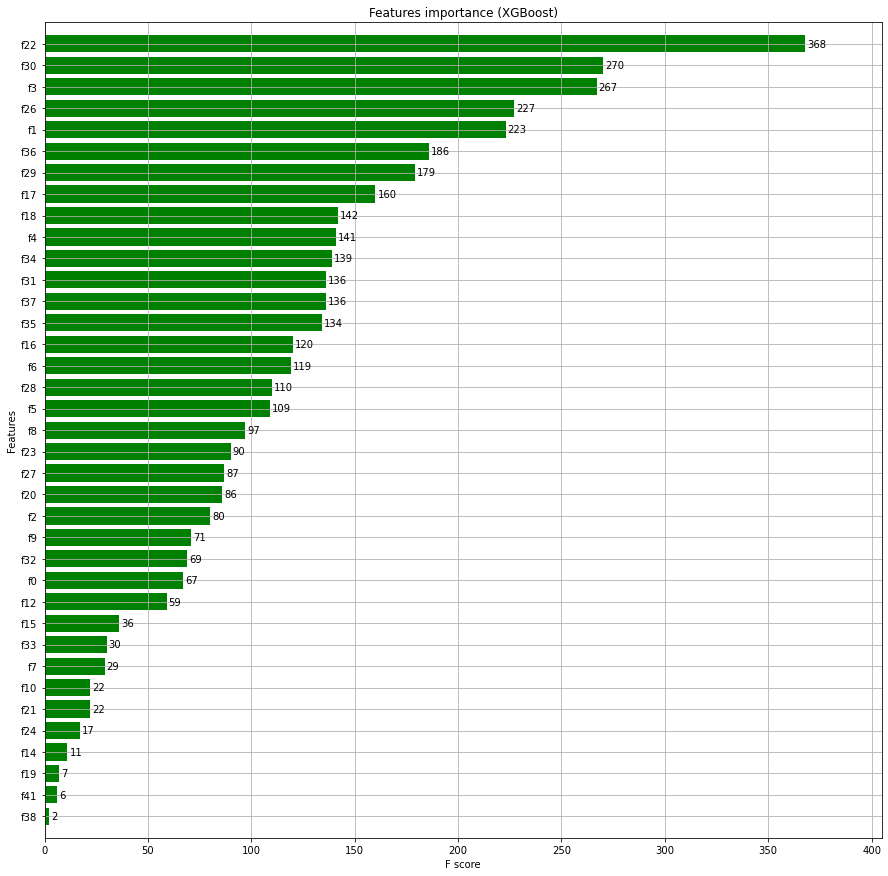

In [64]:
fig, (ax) = plt.subplots(ncols=1, figsize=(15, 15))
xgb.plot_importance(best_xgb, height=0.8,
                    title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()


In [77]:
print("Important Features According to XGBoost: ")
for i in [22,30,3,26,1,36,29,17]:
    print(dts.columns[i])

Important Features According to XGBoost: 
dbID
Std FHR
Gest. Weeks
Mean FHR
pCO2
Peak FHR
Median UC
I.stage


# AUC ROC

AUC ROC Scores
XGBoost: 	 0.9539238375762678
RandomForest: 	 0.9948979591836735
SupportVectorMachines: 	 0.9846938775510203


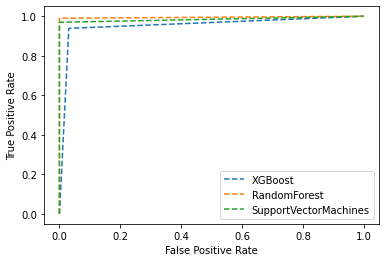

In [76]:
evaluate.plot_auc_roc([('XGBoost', best_xgb), ('RandomForest', best_rf), ('SupportVectorMachines', best_svc)], X_test, y_test)
